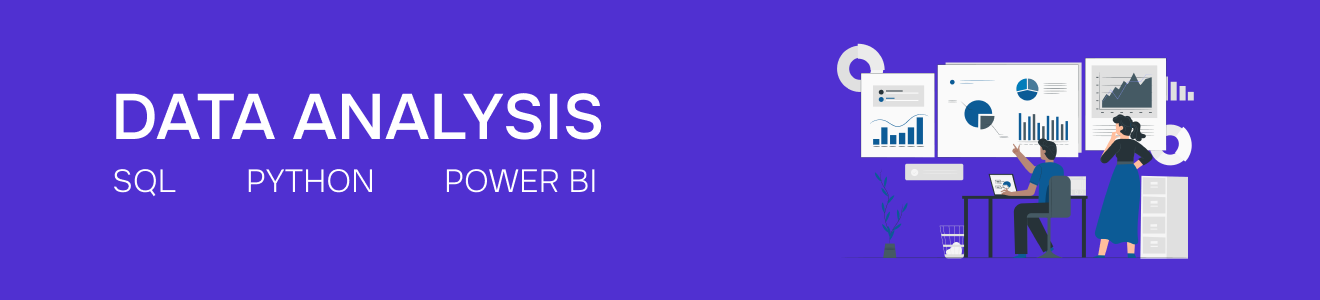

# <center> Study discription

**Data description:**  
Data on train departure and arrival to and from a railway station.  
Main focus on delayed trains.  
Several quantitative indicators are used: passengers, baggage and cargo.  
As well as a number of binary indicators: season, time of day, class of train etc.

**Task Description:**  
It is necessary to make staticsic analysis of departure delays and select a basic model to predict the probability of departure train delays.

**Content of the study:**
1. Data overview
2. Data cleanup
3. Data addition
4. Data insides
5. Model selection
6. Conclusions

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

import datetime

In [157]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [158]:
df = pd.read_csv('C:/Users/abelova/delay/delays2.csv')

# <center> 1. Data overview

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90185 entries, 0 to 90184
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   OD_ID                    90185 non-null  int64  
 1   OD_RAL_CODE              86931 non-null  object 
 2   OD_RST_CODE              90185 non-null  object 
 3   OD_ATD                   90185 non-null  object 
 4   OD_RACT_CODE             89839 non-null  object 
 5   OD_RAC_CODE              66087 non-null  object 
 6   OD_RAP_CODE_DESTINATION  90185 non-null  object 
 7   OD_RAP_CODE_NEXT         90185 non-null  object 
 8   OD_RCT_CODE              90185 non-null  object 
 9   OD_PAX_TOTAL             63841 non-null  float64
 10  OD_BAGGAGE_WEIGHT        62830 non-null  float64
 11  OD_CARGO_WEIGHT          62592 non-null  float64
 12  OD_MAIL_WEIGHT           62556 non-null  float64
 13  OD_PAX_1                 63817 non-null  float64
 14  OD_PAX_2              

In [160]:
df.shape

(90185, 18)

In [161]:
df.describe()

,OD_ID,OD_PAX_TOTAL,OD_BAGGAGE_WEIGHT,OD_CARGO_WEIGHT,OD_MAIL_WEIGHT,OD_PAX_1,OD_PAX_2,OD_PAX_3,OD_PAX_5,delay
count,9.018500e+04,63841.000000,62830.000000,62592.000000,62556.000000,63817.000000,63814.000000,63811.000000,39110.000000,90185.000000
mean,2.337047e+06,130.549615,700.708626,132.915932,17.263828,120.792015,8.478406,1.273887,4.869778,0.297821
std,4.891297e+04,56.098025,855.568348,598.510020,92.490499,50.991645,8.285951,1.671222,6.348081,0.823240
min,2.232756e+06,0.000000,0.000000,0.000000,-11.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.296339e+06,91.000000,300.000000,0.000000,0.000000,85.000000,3.000000,0.000000,1.000000,0.000000
50%,2.338162e+06,134.000000,486.000000,0.000000,0.000000,125.000000,6.000000,1.000000,4.000000,0.000000
75%,2.378823e+06,173.000000,777.000000,46.000000,0.000000,159.000000,11.000000,2.000000,7.000000,0.000000
max,2.423211e+06,735.000000,91500.000000,33888.000000,14527.000000,721.000000,106.000000,20.000000,414.000000,33.000000


# <center> 2. Очистка данных

### <center> 2.1. Подготовка данных

In [162]:
# analyse persent of empty sales in each column
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
OD_ID,0.000000
OD_RAL_CODE,4.000000
OD_RST_CODE,0.000000
OD_ATD,0.000000
OD_RACT_CODE,0.000000
OD_RAC_CODE,27.000000
OD_RAP_CODE_DESTINATION,0.000000
OD_RAP_CODE_NEXT,0.000000
OD_RCT_CODE,0.000000
OD_PAX_TOTAL,29.000000


In [163]:
# delete trains without RAL_CODE, as such trains are unknown ones
df1=df[~df["OD_RAL_CODE"].isnull()]

In [164]:
df.shape, df1.shape

((90185, 18), (86931, 18))

In [165]:
# rename columns
df1.rename(columns={'OD_ID': 'ID', 'OD_RAL_CODE': 'CUS', 'OD_ATD': 'ATD',
                   'OD_RACT_CODE' : 'TRAIN', 'OD_RAC_CODE': 'CODE', 'OD_RST_CODE': 'CHARTER',
                   'ODD_ID': 'DELAY', 'OD_PAX_1': 'ADULT', 'OD_PAX_2': 'CHILDREN', 'OD_PAX_3': 'INFANT',
                   'OD_PAX_5': 'PRM', 'OD_RAP_CODE_DESTINATION' : 'DEST', 'OD_RAP_CODE_NEXT': 'NEXT',
                   'OD_PAX_TOTAL': 'PAX', 'OD_BAGGAGE_WEIGHT': 'BAGGAGE', 'OD_CARGO_WEIGHT': 'CARGO',
                   'OD_MAIL_WEIGHT': 'MAIL', 'OD_RCT_CODE': 'DOM', 'delay': 'DELAY'}, inplace=True)

In [166]:
# check that all trains are unique observations by ID
df1['ID'].value_counts()

2363394    1
2262266    1
2319622    1
2313475    1
2311426    1
          ..
2419336    1
2398854    1
2392709    1
2356245    1
2388566    1
Name: ID, Length: 86931, dtype: int64

In [167]:
df.describe()

,OD_ID,OD_PAX_TOTAL,OD_BAGGAGE_WEIGHT,OD_CARGO_WEIGHT,OD_MAIL_WEIGHT,OD_PAX_1,OD_PAX_2,OD_PAX_3,OD_PAX_5,delay
count,9.018500e+04,63841.000000,62830.000000,62592.000000,62556.000000,63817.000000,63814.000000,63811.000000,39110.000000,90185.000000
mean,2.337047e+06,130.549615,700.708626,132.915932,17.263828,120.792015,8.478406,1.273887,4.869778,0.297821
std,4.891297e+04,56.098025,855.568348,598.510020,92.490499,50.991645,8.285951,1.671222,6.348081,0.823240
min,2.232756e+06,0.000000,0.000000,0.000000,-11.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.296339e+06,91.000000,300.000000,0.000000,0.000000,85.000000,3.000000,0.000000,1.000000,0.000000
50%,2.338162e+06,134.000000,486.000000,0.000000,0.000000,125.000000,6.000000,1.000000,4.000000,0.000000
75%,2.378823e+06,173.000000,777.000000,46.000000,0.000000,159.000000,11.000000,2.000000,7.000000,0.000000
max,2.423211e+06,735.000000,91500.000000,33888.000000,14527.000000,721.000000,106.000000,20.000000,414.000000,33.000000


### <center> 2.2. Изменение типов данных

In [168]:
# transformation of object data type to int, changing string to binar variables
df1['DOM'] = df1['DOM'].apply(lambda DOM: 1 if DOM == "D" else 0)
df1['DELAY'] = df1['DELAY'].apply(lambda delay: 1 if delay >= 1 else 0)

In [169]:
# transformation of object data type to datetime
df1['ATD'] = pd.to_datetime(df1['ATD'], dayfirst = True, infer_datetime_format=True)

In [170]:
# we will analyse only passenger train, both charter and regular
df1['CHARTER'] = df1['CHARTER'].apply(lambda TYPE: 1 if TYPE == "C" else (0 if TYPE == "J" else 2))
df1=df1[df1["CHARTER"]!=2]

In [171]:
df1['CHARTER'].value_counts()

0    84843
1     1268
Name: CHARTER, dtype: int64

In [172]:
df1.describe()

,ID,CHARTER,DOM,PAX,BAGGAGE,CARGO,MAIL,ADULT,CHILDREN,INFANT,PRM,DELAY
count,8.611100e+04,86111.000000,86111.000000,61974.000000,61885.000000,61664.000000,61631.000000,61950.000000,61948.000000,61945.000000,38187.000000,86111.000000
mean,2.337346e+06,0.014725,0.910615,134.259690,710.733570,134.002546,17.521312,124.221824,8.723074,1.310614,4.944693,0.222341
std,4.881322e+04,0.120451,0.285300,52.437885,857.862273,584.433070,93.157172,47.518420,8.279352,1.681036,6.365385,0.415821
min,2.250116e+06,0.000000,0.000000,0.000000,0.000000,0.000000,-11.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.296940e+06,0.000000,1.000000,95.000000,308.000000,0.000000,0.000000,89.000000,3.000000,0.000000,1.000000,0.000000
50%,2.338660e+06,0.000000,1.000000,138.000000,492.000000,0.000000,0.000000,127.000000,7.000000,1.000000,4.000000,0.000000
75%,2.378938e+06,0.000000,1.000000,174.000000,784.000000,49.000000,0.000000,160.000000,12.000000,2.000000,7.000000,0.000000
max,2.423201e+06,1.000000,1.000000,735.000000,91500.000000,33888.000000,14527.000000,721.000000,106.000000,20.000000,414.000000,1.000000


In [173]:
# we replace all empty cells with zeros and change data type to int, as passengers and cargo maybe only integer values
df1 = df1.fillna(0)
df1 = df1.astype({'PAX': np.int64, 'CHILDREN': np.int64, 'ADULT': np.int64, 'INFANT': np.int64, 'PRM': np.int64,
                 'MAIL': np.int64, 'CARGO': np.int64, 'BAGGAGE': np.int64})

### <center> 2.3. Корректировка выбросов

In [174]:
# let's have a look at main statistics
df1.describe()

,ID,CHARTER,DOM,PAX,BAGGAGE,CARGO,MAIL,ADULT,CHILDREN,INFANT,PRM,DELAY
count,8.611100e+04,86111.000000,86111.000000,86111.000000,86111.000000,86111.000000,86111.000000,86111.000000,86111.000000,86111.000000,86111.000000,86111.000000
mean,2.337346e+06,0.014725,0.910615,96.626563,510.779656,95.959088,12.540279,89.367700,6.275354,0.942806,2.192786,0.222341
std,4.881322e+04,0.120451,0.285300,74.935786,794.365763,498.238642,79.206074,68.842668,8.041968,1.542595,4.899227,0.415821
min,2.250116e+06,0.000000,0.000000,0.000000,0.000000,0.000000,-11.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.296940e+06,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.338660e+06,0.000000,1.000000,105.000000,348.000000,0.000000,0.000000,98.000000,4.000000,0.000000,0.000000,0.000000
75%,2.378938e+06,0.000000,1.000000,161.000000,639.000000,2.000000,0.000000,148.000000,9.000000,1.000000,3.000000,0.000000
max,2.423201e+06,1.000000,1.000000,735.000000,91500.000000,33888.000000,14527.000000,721.000000,106.000000,20.000000,414.000000,1.000000


Quick notes:
* large amount of practically empty trains - without passengers and baggage;
* small number of trains with cargo;
* negative minimum value for mail,
* potential outliers for baggage, cargo and PRM (maximum is significantly higher than average).

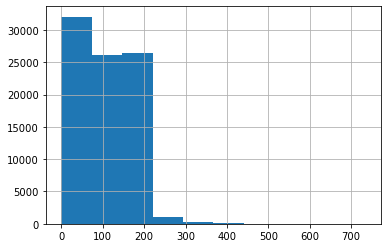

In [175]:
# let's look at passengers distribution, we observe clear predominance of values around 0
df1['PAX'].hist();

In [176]:
# delete trains with insignificant loading of train, as it is necessary to analyze passenger trains
df1 = df1[(df1['PAX']>df1["PAX"].quantile(0.27)) & (df1["PAX"]>0)]
df1.shape

(61949, 18)

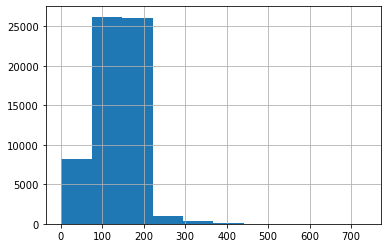

In [177]:
# distribution of passengers has starts to look normal with small tail on the right
# number of passengers from 300 to 700 is possible, so we will not correct this values
df1['PAX'].hist();

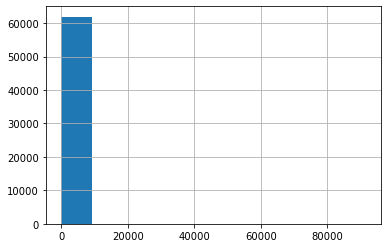

In [178]:
# checking baggage amount distribution
df1['BAGGAGE'].hist();

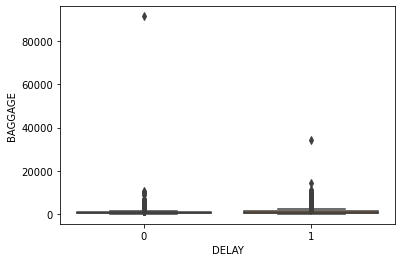

In [179]:
# using another graph to make sure that there are outliers
sns.boxplot(x="DELAY", y="BAGGAGE", data=df1);

In [180]:
# replace unrealistic values (more than two standard deviations) based on the average amount of baggage per passenger
std = df1['BAGGAGE'].std()
bpp = (df1['BAGGAGE']/df1['PAX']).median()
bag = []
for i in range (df1.shape[0]):
    if df1['BAGGAGE'].iloc[i] > 2*std:
        bag.append(df1['PAX'].iloc[i]*bpp)
    else:
        bag.append(df1['BAGGAGE'].iloc[i])
df1['BAG']=bag
df1 = df1.astype({'BAG': np.int64})

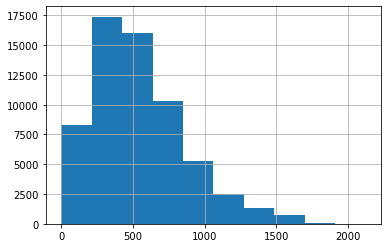

In [181]:
# distribution of passengers has starts to look normal with small tail on the right, matching passenger amount distribution
df1['BAG'].hist();

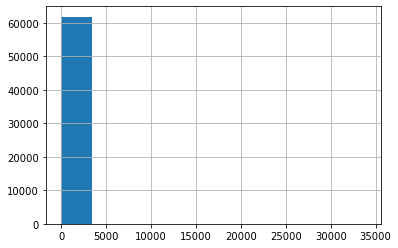

In [182]:
#will make same actions for cargo and mail
df1['CARGO'].hist();

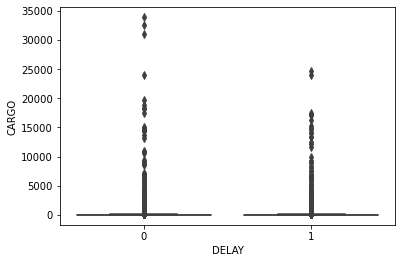

In [183]:
sns.boxplot(x="DELAY", y="CARGO", data=df1);

In [184]:
# 64% of trains observed don't have cargo
df1['CARGO'].value_counts(normalize = True)

0       0.640462
1       0.009040
2       0.005214
3       0.004923
4       0.004649
          ...   
1047    0.000016
3434    0.000016
1323    0.000016
1143    0.000016
1455    0.000016
Name: CARGO, Length: 2187, dtype: float64

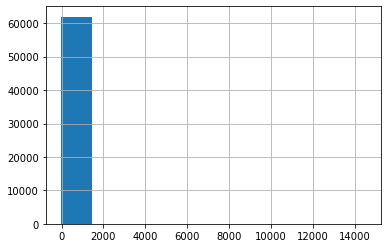

In [185]:
df1['MAIL'].hist();

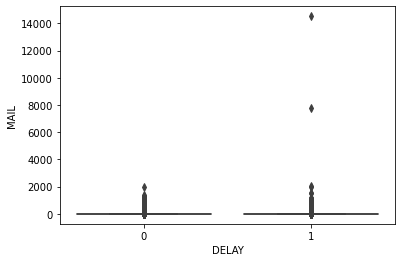

In [186]:
sns.boxplot(x="DELAY", y="MAIL", data=df1);

In [187]:
# 78% of trains observed don't have mail
df1['MAIL'].value_counts(normalize = True)

0      0.777817
1      0.013156
2      0.006877
3      0.005166
4      0.004568
         ...   
721    0.000016
689    0.000016
593    0.000016
497    0.000016
959    0.000016
Name: MAIL, Length: 651, dtype: float64

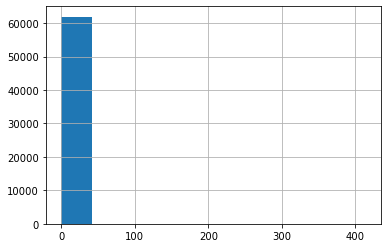

In [188]:
# PRM - person with reduced mobility
df1['PRM'].hist();

In [189]:
# let's estimate most likely number of PRMs, using 0,4% as entry threshold
df1['PRM_new'] = df1['PRM'].apply(lambda p: 16 if p>16 else p)
df1['PRM_new'].value_counts(normalize = True)

0     0.516376
2     0.056159
8     0.054077
1     0.052350
4     0.050929
3     0.048233
5     0.048072
6     0.042293
7     0.040582
16    0.028201
9     0.013204
12    0.013156
10    0.011574
11    0.010638
15    0.005488
13    0.004375
14    0.004294
Name: PRM_new, dtype: float64

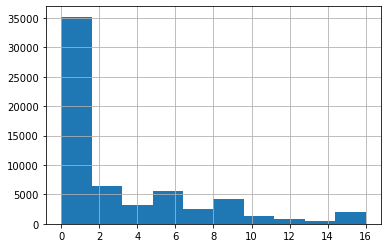

In [190]:
# checking final PRM distribution
df1['PRM_new'].hist();

# <center> 3. Adding data

### <center> 3.1. Adding data from dictionaries

In [191]:
# adding arriving trains delay data
ar = pd.read_csv('C:/Users/abelova/delay/arrivals.csv')

In [192]:
# changing data types
ar['OA_ETA'] = pd.to_datetime(ar['OA_ETA'], dayfirst = True, infer_datetime_format=True)
ar['OA_ATA'] = pd.to_datetime(ar['OA_ATA'], dayfirst = True, infer_datetime_format=True)

In [193]:
# converting delay time to minutes type
ar['TIME_DELAY'] = ar['OA_ATA'] - ar['OA_ETA']
ar['DELAY_MIN'] = ar['TIME_DELAY'] / pd.Timedelta(minutes=1)

In [194]:
# if delay time minutes is more than 0, than such train is delayed
porog = 0
ar['AR_DELAY'] = ar['DELAY_MIN'].apply(lambda AR_DELAY: 1 if AR_DELAY > 0 else 0)

In [195]:
# deleting unnecessary columns and saving arriving trains to separate dataframe
ar['OA_OD_ID'] = ar['OA_OD_ID'].fillna(0)
ar = ar.astype({'OA_OD_ID': np.int64})
ar1 = pd.DataFrame({'ID': ar['OA_OD_ID'], 'AR_DELAY': ar['AR_DELAY']})
ar1.head()

,ID,AR_DELAY
0,2261038,0
1,2261033,0
2,2261036,0
3,2261507,0
4,2261518,0


In [196]:
# let's connect the delays for departure and arrival using train index for departure
df1 = df1.merge(ar1, on = 'ID')

In [197]:
# adding data of train size
TR = pd.read_excel('C:/Users/abelova/delay/Mapping trains.xlsx')
TR.head()

,TRAIN,LG
0,100,0
1,146,0
2,150,0
3,172,0
4,182,0


In [198]:
df1 = df1.merge(TR, on = 'TRAIN')

### <center> 3.2. Adding features

In [199]:
# let's add variables for time of day and season of year
df1['TIME'] = df1['ATD'].dt.time
df1['DATE'] = df1['ATD'].dt.date
df1['NIGHT'] = df1['TIME'].apply(lambda time: 1 if datetime.time(22,0,0)<time or time<datetime.time(6,0,0) else 0)
df1['SUMMER'] = df1['DATE'].apply(lambda date: 1 if datetime.date(2022,3,27)<date<datetime.date(2022,10,29) else 0)

In [200]:
# deleting unnecessary columns
df1.drop(['CARGO', 'TIME', 'DATE', 'MAIL', 'PRM', 'ATD', 'BAGGAGE'], inplace = True, axis = 1)

# <center> 4. Data insides

In [201]:
df1.describe()

,ID,CHARTER,DOM,PAX,ADULT,CHILDREN,INFANT,DELAY,BAG,PRM_new,AR_DELAY,LG,NIGHT,SUMMER
count,5.976600e+04,59766.000000,59766.000000,59766.000000,59766.000000,59766.000000,59766.000000,59766.000000,59766.000000,59766.000000,59766.000000,59766.000000,59766.000000,59766.000000
mean,2.335093e+06,0.018439,0.883847,134.097982,123.914567,8.830271,1.316936,0.306378,545.308135,2.897450,0.048573,0.015126,0.246796,0.736907
std,4.769742e+04,0.134532,0.320411,52.556881,47.586527,8.340535,1.684227,0.460993,322.940246,4.120645,0.214975,0.122054,0.431151,0.440316
min,2.250117e+06,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.295359e+06,0.000000,1.000000,95.000000,88.000000,3.000000,0.000000,0.000000,307.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.337028e+06,0.000000,1.000000,137.000000,127.000000,7.000000,1.000000,0.000000,489.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.375902e+06,0.000000,1.000000,174.000000,160.000000,12.000000,2.000000,1.000000,719.000000,5.000000,0.000000,0.000000,0.000000,1.000000
max,2.416099e+06,1.000000,1.000000,735.000000,721.000000,106.000000,20.000000,1.000000,2125.000000,16.000000,1.000000,1.000000,1.000000,1.000000


In this analysis, we will not use a number of string indicators, we will leave only numerical and binary variables, but we  download full dataset separately for further visualization.

In [202]:
writer = pd.ExcelWriter('C:/Users/abelova/delay/delay_ds_2.xlsx')
df1.to_excel(writer)
writer.save()

In [205]:
df_final = df1.drop(['ID', 'CUS', 'TRAIN', 'CODE', 'DEST', 'NEXT'], axis = 1)

In [206]:
df_final.head()

,CHARTER,DOM,PAX,ADULT,CHILDREN,INFANT,DELAY,BAG,PRM_new,AR_DELAY,LG,NIGHT,SUMMER
0,0,1,175,168,6,1,1,562,0,0,0,0,0
1,0,1,170,162,7,1,0,430,0,0,0,0,0
2,0,1,180,171,7,2,1,506,0,0,0,0,0
3,0,1,173,167,4,2,0,550,0,0,0,0,0
4,0,1,106,103,3,0,1,368,0,0,0,0,0


### <center> 3.1. Influence of binary features

Let's consider all variables that can affect the target attribute of departure delay separately.

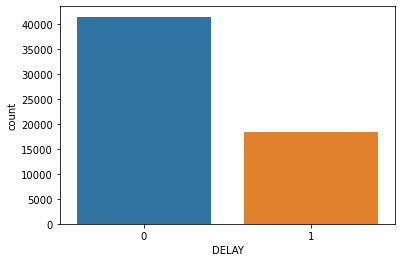

In [207]:
sns.countplot(df_final["DELAY"]);

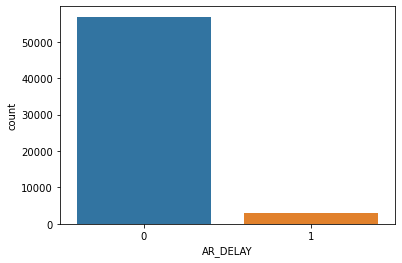

In [208]:
sns.countplot(df_final["AR_DELAY"]);

AR_DELAY,0,1
DELAY,,
0,0.663555,0.030067
1,0.287873,0.018506


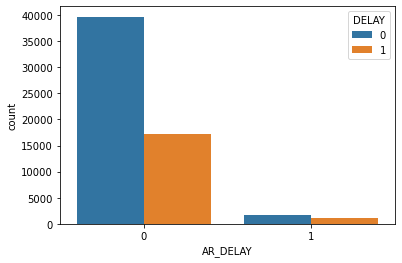

In [209]:
sns.countplot(x="AR_DELAY", hue="DELAY", data=df_final)
pd.crosstab(df_final["DELAY"], df_final["AR_DELAY"], normalize = True)

There are significantly more delayed trains departing than delayed trains arriving, which means that delays arriving do not always mean delays departing. The number of timely and late trains for departure is in the ratio of about 2.3 to 1, but for arrival: 1.6 to 1.

<AxesSubplot:xlabel='DOM', ylabel='count'>

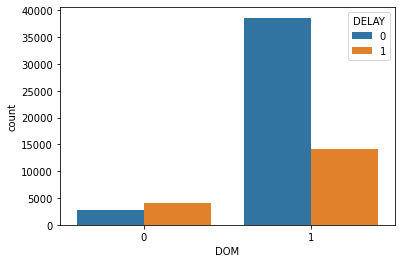

In [210]:
sns.countplot(x="DOM", hue="DELAY", data=df_final)

On international routes trains are more often delayed than depart on time, on domestic lines trend is reversed.

CHARTER,0,1
DELAY,,
0,0.685323,0.008299
1,0.296239,0.010140


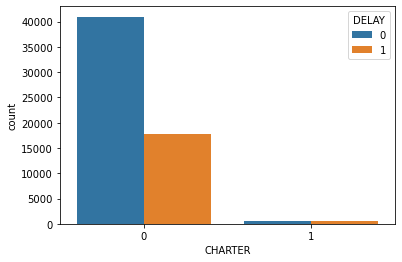

In [211]:
sns.countplot(x="CHARTER", hue="DELAY", data=df_final)
pd.crosstab(df_final["DELAY"], df_final["CHARTER"], normalize = True)

We assume that charter trains are more likely to be delayed than regular ones.

LG,0,1
DELAY,,
0,0.687163,0.006459
1,0.297711,0.008667


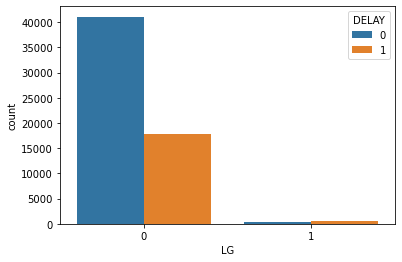

In [212]:
sns.countplot(x="LG", hue="DELAY", data=df_final)
pd.crosstab(df_final["DELAY"], df_final["LG"], normalize = True)

Amount of delayes large traines is highter than amount of ontime latge trains. Large trains departure on time less often than small ones. 

NIGHT,0,1
DELAY,,
0,0.532477,0.161145
1,0.220728,0.085651


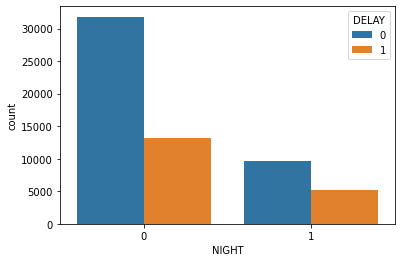

In [214]:
sns.countplot(x="NIGHT", hue="DELAY", data=df_final)
pd.crosstab(df_final["DELAY"], df_final["NIGHT"], normalize = True)

Time of day has little effect on trains delays, the ratio of delayed and timely trains is almost same regardless of time of day. But we note that at night it is still more likely that trains will be delayed, than in the daytime.

SUMMER,0,1
DELAY,,
0,0.171134,0.522488
1,0.091959,0.214420


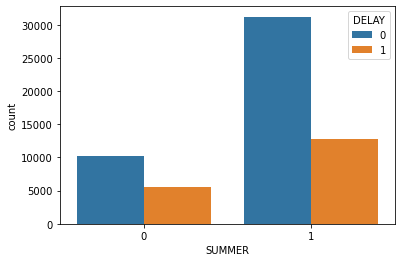

In [215]:
sns.countplot(x="SUMMER", hue="DELAY", data=df_final), 
pd.crosstab(df_final["DELAY"], df_final["SUMMER"], normalize = True)

In the winter season, the number of ontime trains per delayed train was less (1.9 to 1) than in the summer season (2.4 to 1). Let's assume that the probability of a delay in winter is slightly higher than in summer.

### <center> 3.2. Influence of numerical features

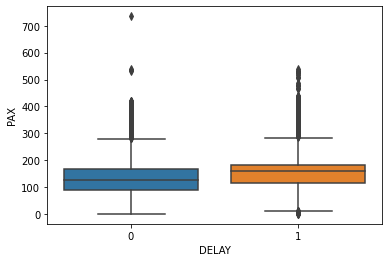

In [216]:
sns.boxplot(x="DELAY", y="PAX", data=df_final);

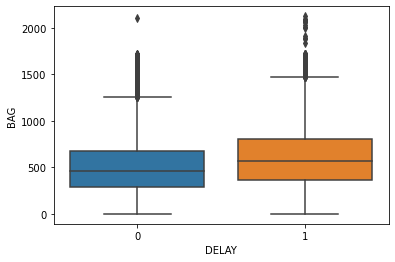

In [217]:
sns.boxplot(x="DELAY", y="BAG", data=df_final);

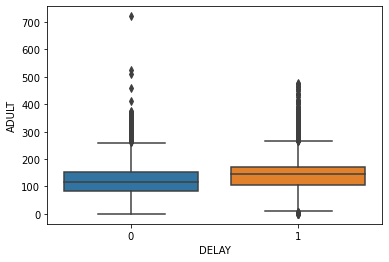

In [218]:
sns.boxplot(x="DELAY", y="ADULT", data=df_final);

Delayed trains have median number of passengers, baggage and adults more than trains that take off on time. Which is consonant with the hypothesis of large trains. We will assume that increase in number of passengers raises chances of train delay.

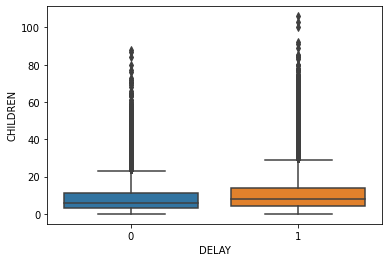

In [219]:
sns.boxplot(x="DELAY", y="CHILDREN", data=df_final);

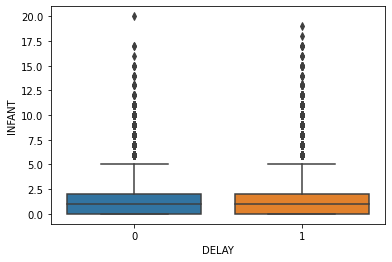

In [220]:
sns.boxplot(x="DELAY", y="INFANT", data=df_final);

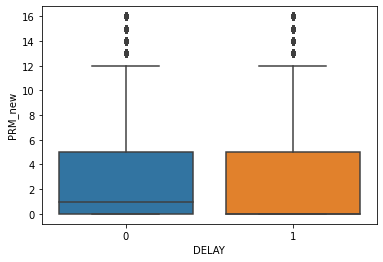

In [221]:
sns.boxplot(x="DELAY", y="PRM_new", data=df_final);

The connection of other passengers categories is traced little less, so we will conduct a correlation analysis.

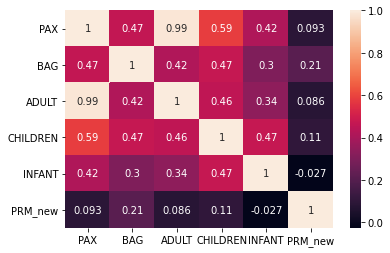

In [222]:
cols = ['PAX', 'BAG', 'ADULT', 'CHILDREN', 'INFANT', 'PRM_new']
hm = sns.heatmap(df_final[cols].corr(), cbar = True, annot = True)

ADULT and PAX indicators are very strongly correlated, we exclude PAX as the sum of all categories of passengers.

In [223]:
df_final = df_final.drop(['PAX'], axis = 1)

In [224]:
df_final.head()

,CHARTER,DOM,ADULT,CHILDREN,INFANT,DELAY,BAG,PRM_new,AR_DELAY,LG,NIGHT,SUMMER
0,0,1,168,6,1,1,562,0,0,0,0,0
1,0,1,162,7,1,0,430,0,0,0,0,0
2,0,1,171,7,2,1,506,0,0,0,0,0
3,0,1,167,4,2,0,550,0,0,0,0,0
4,0,1,103,3,0,1,368,0,0,0,0,0


# <center> 5. Building a model

We will test several models to predict probability of train departure delays. We will use basic models with hyperparameter optimization.

### <center> 5.1. DT - Decision tree

In [225]:
# we will use cross-validation with k=5, let's estimate average percent of correct answers in training sample
y = df_final["DELAY"].astype("int")
X = df_final.drop("DELAY", axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17)
first_tree = DecisionTreeClassifier(random_state=17)
round(np.mean(cross_val_score(first_tree, X_train, y_train, cv=5)),3)

0.622

In [226]:
# let's find best depth of decision tree
tree_params = {"max_depth": np.arange(1, 12), "max_features": [0.5, 0.7, 1]}
tree_grid = GridSearchCV(first_tree, tree_params, cv=5, n_jobs=-1)
tree_grid.fit(X_train, y_train);
tree_grid.best_score_, tree_grid.best_params_

(0.7262884085960025, {'max_depth': 4, 'max_features': 0.7})

In [227]:
# taking into account the optimization of the hyperparameter, 
# the average percentage of correct answers increased by 10% in training sample
second_tree = DecisionTreeClassifier(max_depth=4)
round(np.mean(cross_val_score(second_tree, X_train, y_train, cv=5)),3)

0.726

In [229]:
# let's estimate percent of correct model predictions in validation sample without optimizing hyperparameter
first_tree = DecisionTreeClassifier().fit(X_train, y_train)
round(first_tree.score(X_valid, y_valid), 3)

0.623

In [231]:
# let's estimate percent of correct model predictions in validation sample with optimizing hyperparameter
# it grows by 10%, as in training sample
second_tree = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)
round(second_tree.score(X_valid, y_valid),3)

0.725

### <center> 5.2. KNN - k Nearest Neighbor

In [233]:
# using cross-validation with k=5
first_knn = KNeighborsClassifier()
round(np.mean(cross_val_score(first_knn, X_train, y_train, cv=5)),3)

0.674

In [234]:
# finding best number of neighbors
knn_params = {"n_neighbors": range(12, 15)}
knn_grid = GridSearchCV(first_knn, knn_params, cv=5)
knn_grid.fit(X_train, y_train);
knn_grid.best_score_, knn_grid.best_params_

(0.7038675195803599, {'n_neighbors': 14})

In [236]:
# let's estimate percent of correct model predictions in validation sample without optimizing hyperparameter
first_knn = KNeighborsClassifier().fit(X_train, y_train)
round(first_knn.score(X_valid, y_valid),3)

0.675

In [238]:
# let's estimate percent of correct model predictions in validation sample with optimizing hyperparameter, shows 3% growth
second_knn = KNeighborsClassifier(n_neighbors = 14).fit(X_train, y_train)
round(second_knn.score(X_valid, y_valid), 3)

0.707

### <center> 5.3. Logit - Logistic regression

In [239]:
# move on logistic regression method
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)
round(logit.score(X_train, y_train), 3), round(logit.score(X_valid, y_valid), 3),

(0.721, 0.721)

In [240]:
# let's pick up regularization coefficient
grid_logit = GridSearchCV(
    logit, param_grid={'C': [2,3,4,5,6,7,8,9]}, cv=3, n_jobs=-1, return_train_score=True
)
grid_logit.fit(X_train, y_train)
grid_logit.best_params_, grid_logit.best_score_

({'C': 3}, 0.7212209908453427)

In [241]:
round(grid_logit.score(X_valid, y_valid),3)

0.721

In [242]:
second_logit = LogisticRegression(C=3, n_jobs=-1, random_state=7)
second_logit.fit(X_train, y_train)

LogisticRegression(C=3, n_jobs=-1, random_state=7)

In [243]:
round(second_logit.score(X_train, y_train), 3), round(second_logit.score(X_valid, y_valid), 3),

(0.722, 0.721)

Taking into account selection of regularization coefficient, model shows same accuracy as without it. 

### <center> 5.4. RF - Random forest

In [249]:
# Similar solution move for random forest method
forest = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)

In [250]:
forest.fit(X_train, y_train)
(round(forest.score(X_train, y_train), 3), round(forest.score(X_valid, y_valid), 3))

(0.999, 0.709)

### <center> 5.5. Selection model results

Quality of correctly guessed answers should be at least higher than percentage of delayed trains departuring, otherwise the model does not make sense:

In [247]:
round(1 - np.mean(y),3)

0.694

Let's look at percent of correctly giessed answers for all 4 models.

In [251]:
DT = round(second_tree.score(X_valid, y_valid),3)
KNN = round(second_knn.score(X_valid, y_valid), 3)
LOGIT = round(second_logit.score(X_valid, y_valid), 3)
RT = round(forest.score(X_valid, y_valid), 3)

In [253]:
print('\n', round(1 - np.mean(y),3), '- minimum', 
      '\n', DT,'- DT', '\n', KNN, '- KNN', '\n', LOGIT, '- LOGIT', '\n', RT, '- RT')


 0.694 - minimum 
 0.725 - DT 
 0.707 - KNN 
 0.721 - LOGIT 
 0.709 - RT


Thus, largest percentage of correctly guessed values is observed using decision tree and logistic regression models.  
Let's add a new train with certain parameters and estimate probability of delay for departure.

In [255]:
new_train = {'CHARTER': 0, 'DOM': 1, 'ADULT': 150, 'CHILDREN': 10, 'INFANT': 1,
              'BAG': 1120, 'PRM_new': 2, 'AR_DELAY': 0, 'LG': 0, 'NIGHT': 1, 'SUMMER':1}
df_new_train = X.append(new_train, ignore_index=True)

In [256]:
df_new_train.tail(1)

,CHARTER,DOM,ADULT,CHILDREN,INFANT,BAG,PRM_new,AR_DELAY,LG,NIGHT,SUMMER
59766,0,1,150,10,1,1120,2,0,0,1,1


In [258]:
second_tree.predict_proba(df_new_train)[59766, 1]

0.3439807258879304

In [257]:
second_logit.predict_proba(df_new_train)[59766, 1]

0.38645540511177257

Probability of delaying new train is conditionally estimated in 34-39%.

# <center> 6. Conclusion

1. Arrival delays do not always mean departure delays, and there are significantly more delayed departure trains than delayed arrival trains.
2. The probability of delay increases if train is international, charter and performed on large train.
3. Trains are more likely to be delayed during the winter season and at night.
4. The increase in number of passengers and baggage directly affects probability of delay, and number of cargo and mail does not have significant impact.
5. All predictive models exceed the minimum requirement, taking into account cross-validation and check on validation sample,  best are decision tree and logistic regression models.